In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import oracles as oracle
import model as md
import time
import pickle

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 3, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [4]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,length,Free Flow Time
0,1,3,4938.061523,16.106817,0.238965
2,1,7,7309.824707,16.058741,0.222813
4,1,9,1164.374878,17.455400,0.402046


In [5]:
correspondence_matrix = handler.from_dict_to_cor_matr(graph_correspondences, n)
T = handler.create_C(df, n, column_name='Free Flow Time')
# C = handler.create_C(df, n, column_name='length')
np.savetxt('data/T.csv', T, delimiter=',')

L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = handler.distributor_L_W(L)
W = handler.distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)

print('people_num: ', people_num)

people_num:  65576.37543100001


In [6]:
T[0][6]

0.22281299531459808

##### Подумаем над T
В данных по Москве время в минутах. В этих данных время по часам! ('Time: hours, distance: miles'). Поэтому альфа получается таким большим, оно масштабирует. В Москве время было в минутах. Также в T много нулей, поэтому там, где стоят nan, поставим по 100 часов, типа много затрат и поэтому никто так не ездит (сделано там, где инициализируется cost_matrix)

##### Запускаем Синхорна для поиска лучшего alpha

In [7]:
num_iter = 2500
alpha, beta = 1.0, 1.0
alpha_range  = np.arange(0.0, 7500.0, 250)

best_matrix = None
min_reconstruction_error = np.inf
best_alpha, best_beta = np.nan, np.nan
eps = 10**(-3)

s = skh.Sinkhorn(n, L, W, people_num, num_iter, eps)

er_list = []

for alpha_idx in range(len(alpha_range)):
    alpha = alpha_range[alpha_idx]
    cost_matrix = np.nan_to_num(T * alpha, nan=100)
    rec = s.iterate(cost_matrix)
        
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er = np.sqrt( er / np.sum(np.nan_to_num(correspondence_matrix, nan=0.0)) )
    er_list.append(er)

    if er < min_reconstruction_error:
        min_reconstruction_error = er
        best_alpha  = alpha_range[alpha_idx]
        best_matrix = rec

In [8]:
min_reconstruction_error

0.2522415874218719

In [9]:
er_list[0] - min_reconstruction_error

0.08397520349964538

In [10]:
best_alpha

7250.0

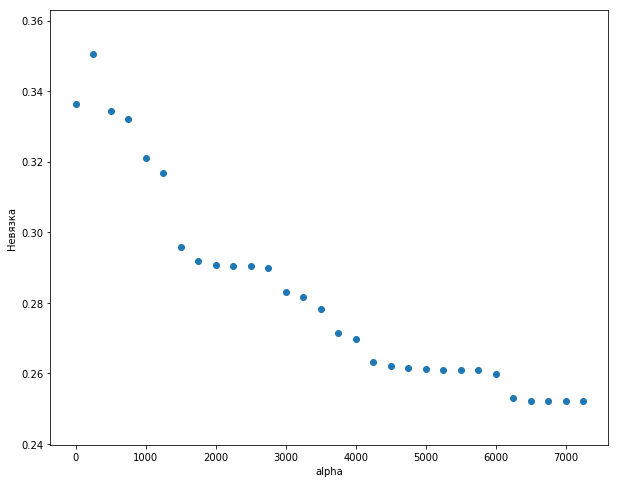

In [11]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(alpha_range, er_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()
fig.savefig('KEV_res/EMA' + str(len(alpha_range)) + '.png')

##### Best recovery corr matrix  

In [12]:
for line in best_matrix:
    print(line)

[ 27.09687137  30.47050069   0.           0.02704176   0.02621504
  29.46755338   0.           0.02746034   0.          62.63684084
   0.02621581  10.9483304   14.83376707  14.89646379   0.02610934
  12.62808475  13.33465381  12.6184458    0.02790875  20.62842876
  78.81186131  23.14134532 104.50649289  99.5046487   95.91915427
  91.71022885   0.02887294   0.02815576  87.87273342  35.81647831
  38.54347682  37.65639675  35.02878538   0.03102483  24.37604731
  42.99731586   9.06913801   9.21174072   9.14274399   9.41418729
   0.0266219   58.16093892  19.2306159   19.15159591  18.95239874
  18.87573218   0.02692601 111.0552664    6.88534506  14.4849775
  14.83545435  58.98286074  31.38668266  66.2269943    3.83412614
   3.83412614  25.62170099   9.38935945  24.77487975  30.32468323
  16.08474227  12.57207754  13.07279522  12.57236787  13.11584002
  12.57236787  26.29806637   0.02609077  43.49131171   0.02655723
   0.02880182   0.02773731   0.02637736   0.02641834]
[18.04569758 20.2924327

##### Multi-stage

In [ ]:
best_correcpondences_dict = handler.from_cor_matrix_to_dict(best_matrix)

model = md.Model(graph_data, best_correcpondences_dict, 
                 total_od_flow, mu = 0, rho = 0.15)

max_iter = 300

for i, eps_abs in enumerate(np.logspace(1,3,1)):
    
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'multi-stage', 
                                    solver_kwargs = solver_kwargs, 
                                    verbose = False)

eps_abs = 10.0
multi-stage model....


In [ ]:
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
print('Time ratio =', np.max(result
                                ['times'] / graph_data['graph_table']
                                ['Free Flow Time']))
print('Flow excess =', np.max(result
                                ['flows'] / graph_data['graph_table']
                                ['Capacity']) - 1, end = '\n\n')

In [ ]:
flows = []
times = []
iter_nums = []
primal_vals = []
dual_vals = []

flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

In [ ]:
plt.plot(np.arange(len(dual_vals[-1])), dual_vals[-1] - np.min(dual_vals[-1]), label='dual')
plt.plot(np.arange(len(primal_vals[-1])), primal_vals[-1] - np.min(primal_vals[-1]), label='primal')
plt.plot(np.arange(len(result['duality_gap_history'])), 
         result['duality_gap_history'] - np.min(result['duality_gap_history']), 
         label='duality gap')

plt.legend()
plt.yscale('log')
plt.show()